<a href="https://colab.research.google.com/github/Terry-Migwi/Sentiment_Analysis/blob/main/EDA_CDs_Vinyl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Defining the question

This notebook conducts exploratory data analysis on amazon sentiment reviews using pyspark. The following questions have been answered:
1. How many years' of reviews are featured in the dataset?
2. What are the most popular reviews for CDs and Vinyl products?
3. What are the top 30 most frequently used words to describe the products?

In [ ]:
 cx# Download Java and Spark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# Set up the paths

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
# Create a Spark session

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark.conf.set("spark.sql.caseSensitive", True) # Avoid error "Found duplicate column(s) in the data schema"
spark

In [ ]:
# read the data using json
import pandas as pd
import gzip
import json

# import libraries for data manipulation and visualization

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

# Use regular expression
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Metadata

In [ ]:
# Initiate an empty list to store sliced dataframes (chunks)
myList = []

# Specify the chunksize
chunksize = 1000

# nrows should be more than the total number of rows in the whole file
for chunk in pd.read_json('/content/drive/MyDrive/Colab Notebooks/meta_CDs_and_Vinyl.json.gz', compression='gzip', nrows=10000000, lines=True, chunksize=chunksize):
    myList.append(chunk)

# put the chunks together
metaData = pd.concat(myList,axis=0)

In [ ]:
# preview the top of the data
metaData.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[CDs & Vinyl, Christian]",,[],,Songs for the Shepherd,"[B0016CP2GS, B0000075PB, B0000275QQ, B00000I7J...",,Keith Green,[],"123,896 in CDs & Vinyl (","[B0016CP2GS, B00000I7JO, B00000I9AH, B00P826ZR...","<img src=""https://images-na.ssl-images-amazon....",,NaN,,0001393774,[],[],NaN
1,"[CDs & Vinyl, Christian, Pop & Contemporary]",,[],,Lift Him Up With Ron Kenoly VHS,"[6303908845, 6303646611, B000008GO1]",,,[],"284,935 in Movies & TV (",[B00000DUDE],Movies & TV,,NaN,,0001501348,[],[],NaN
2,"[CDs & Vinyl, Christian, Children's]",,[],,I Love You,[],,Integrity Music,[],"1,138,833 in CDs & Vinyl (",[],"<img src=""https://images-na.ssl-images-amazon....",,NaN,,0001515209,[],[],NaN


In [ ]:
metaData.shape

(516914, 19)

In [ ]:
metaData.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')

In [ ]:
metaData.category.nunique

<bound method IndexOpsMixin.nunique of 0                             [CDs & Vinyl, Christian]
1         [CDs & Vinyl, Christian, Pop & Contemporary]
2                 [CDs & Vinyl, Christian, Children's]
3                 [CDs & Vinyl, Christian, Children's]
4                 [CDs & Vinyl, Christian, Children's]
                              ...                     
516909                              [CDs & Vinyl, Pop]
516910                          [CDs & Vinyl, Country]
516911                   [CDs & Vinyl, Pop, Vocal Pop]
516912                              [CDs & Vinyl, Pop]
516913                              [CDs & Vinyl, Pop]
Name: category, Length: 516914, dtype: object>

### EDA

In [ ]:
# First upload a review data set to the runtime

# Initiate an empty list to store sliced dataframes (chunks)
myList = []

# Specify the chunksize
chunksize = 1000

# nrows should be more than the total number of rows in the whole file
for chunk in pd.read_json('/content/drive/MyDrive/Colab Notebooks/CDs_and_Vinyl_5.json.gz', compression='gzip', nrows=10000000, lines=True, chunksize=chunksize):
    myList.append(chunk)

# put the chunks together
myData = pd.concat(myList,axis=0)

In [ ]:
# preview the top of the data
myData.head(3)

,reviewerID,asin,reviewerName,verified,reviewText,overall,reviewTime,summary,unixReviewTime,style,vote,image
0,A1H1DL4K669VQ9,0001393774,Judith Paladino,True,Love it!! Great seller!,5,"04 29, 2016",Five Stars,1461888000,NaN,NaN,NaN
1,A3V5XBBT7OZG5G,0001393774,gflady,True,One of my very favourite albums from one of my...,5,"02 23, 2016",One of my very favourite albums from one of my...,1456185600,NaN,NaN,NaN
2,A3SNL7UJY7GWBI,0001393774,Lady Leatherneck,True,"THank you Jesus Lord God, that brother Green's...",5,"02 11, 2016",Five Stars,1455148800,NaN,NaN,NaN


In [ ]:
# shape of the data
myData.shape

(1443755, 12)

In [ ]:
# columns
myData.columns

Index(['reviewerID', 'asin', 'reviewerName', 'verified', 'reviewText',
       'overall', 'reviewTime', 'summary', 'unixReviewTime', 'style', 'vote',
       'image'],
      dtype='object')

In [ ]:
# datatypes
myData.dtypes

reviewerID        object
asin              object
reviewerName      object
verified            bool
reviewText        object
overall            int64
reviewTime        object
summary           object
unixReviewTime     int64
style             object
vote              object
image             object
dtype: object

In [ ]:
# convert reviewdate from string to datetime format
myData['date'] = pd.to_datetime(myData['reviewTime'])

In [ ]:
# datatypes
myData.dtypes

reviewerID                object
asin                      object
reviewerName              object
verified                    bool
reviewText                object
overall                 category
reviewTime                object
summary                   object
unixReviewTime             int64
style                     object
vote                      object
image                     object
date              datetime64[ns]
dtype: object

In [ ]:
myData.head()

,reviewerID,asin,reviewerName,verified,reviewText,overall,reviewTime,summary,unixReviewTime,style,vote,image,date
0,A1H1DL4K669VQ9,0001393774,Judith Paladino,True,Love it!! Great seller!,5,"04 29, 2016",Five Stars,1461888000,NaN,NaN,NaN,2016-04-29
1,A3V5XBBT7OZG5G,0001393774,gflady,True,One of my very favourite albums from one of my...,5,"02 23, 2016",One of my very favourite albums from one of my...,1456185600,NaN,NaN,NaN,2016-02-23
2,A3SNL7UJY7GWBI,0001393774,Lady Leatherneck,True,"THank you Jesus Lord God, that brother Green's...",5,"02 11, 2016",Five Stars,1455148800,NaN,NaN,NaN,2016-02-11
3,A3478QRKQDOPQ2,0001393774,jacki,True,I recall loving his other albums and maybe thi...,5,"11 28, 2015",forgot but I figured on some of these artists ...,1448668800,NaN,NaN,NaN,2015-11-28
4,A23M5VTSN2C3H1,0001393774,Caliope,True,Keith Green was a pioneer in the field of Chri...,5,"12 16, 2014",and I have loved every album he did,1418688000,NaN,NaN,NaN,2014-12-16


In [ ]:
# split the dates for visualization
# myData[["year", "month", "day"]] = myData["date"].str.split("-", expand = True)
# print("\nNew DataFrame:")

#Create 3 additional columns
myData['day'] = myData['date'].dt.day
myData['month'] = myData['date'].dt.month
myData['year'] = myData['date'].dt.year

myData.head(3)


,reviewerID,asin,reviewerName,verified,reviewText,overall,reviewTime,summary,unixReviewTime,style,vote,image,date,day,month,year
0,A1H1DL4K669VQ9,0001393774,Judith Paladino,True,Love it!! Great seller!,5,"04 29, 2016",Five Stars,1461888000,NaN,NaN,NaN,2016-04-29,29,4,2016
1,A3V5XBBT7OZG5G,0001393774,gflady,True,One of my very favourite albums from one of my...,5,"02 23, 2016",One of my very favourite albums from one of my...,1456185600,NaN,NaN,NaN,2016-02-23,23,2,2016
2,A3SNL7UJY7GWBI,0001393774,Lady Leatherneck,True,"THank you Jesus Lord God, that brother Green's...",5,"02 11, 2016",Five Stars,1455148800,NaN,NaN,NaN,2016-02-11,11,2,2016


In [ ]:
myData.dtypes

reviewerID                object
asin                      object
reviewerName              object
verified                    bool
reviewText                object
overall                    int64
reviewTime                object
summary                   object
unixReviewTime             int64
style                     object
vote                      object
image                     object
date              datetime64[ns]
day                        int64
month                      int64
year                    category
dtype: object

1. How many years' of reviews are in the dataset?
2. Which years have the most number of reviews?

In [ ]:
# change year into category datatype
myData['year'] = myData['year'].astype('category')

[Text(0.5, 1.0, 'Count plot of years')]

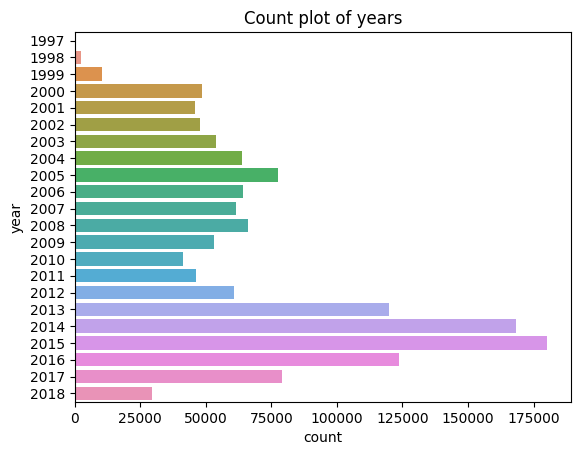

In [ ]:
# countplot of year
sns.countplot(y = myData['year'], orient = 'h').set(title = "Count plot of years")


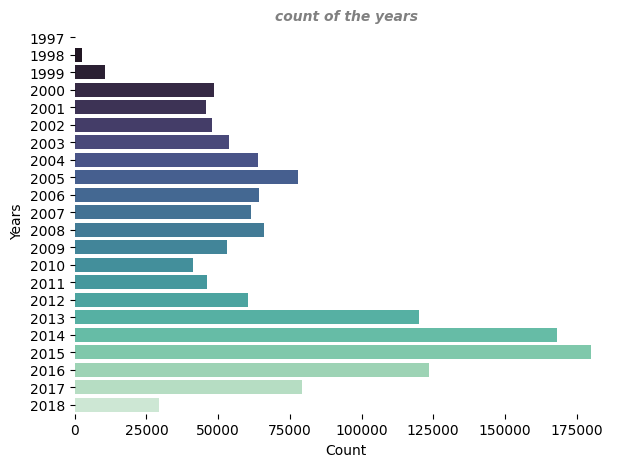

In [ ]:
f, ax = plt.subplots(figsize=(7,5))

sns.countplot(y = myData['year'], orient = 'h', palette = 'mako')


# Add label to horiztontal axis
ax.set_xlabel("Count")

# Remove ylabel
ax.set_ylabel("Years")

# Add a title
ax.set_title("count of the years", fontdict={'size': 10, 'style':'oblique', 'weight': 'heavy', 'color': 'grey'})

# Remove the border line
sns.despine(left=True, bottom=True)

plt.show()

In [ ]:
# convert overall column to categorical data
myData['overall'] = myData['overall'].astype('category')

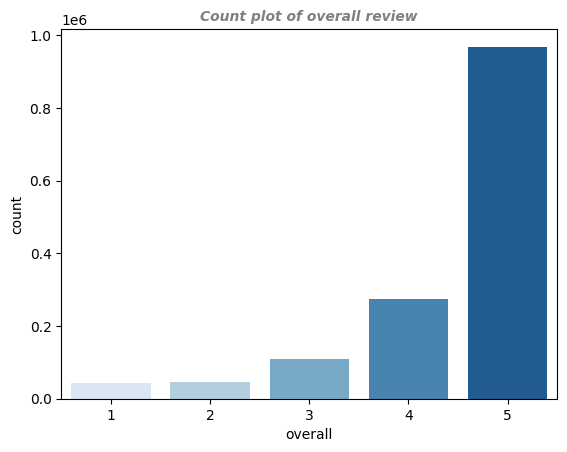

In [ ]:
# sequential_colors = sns.color_palette("mako", 10)
# sns.palplot(sequential_colors)

# sns.color_palette("mako", as_cmap=True)
import matplotlib.pyplot as plt

# countplot of overall
chart = sns.countplot(x = myData['overall'], palette = 'Blues')
chart.set_title("Count plot of overall review", fontdict={'size': 10, 'style':'oblique', 'weight': 'heavy', 'color': 'grey'})
plt.show()

What are the number of verified and unverified reviews?

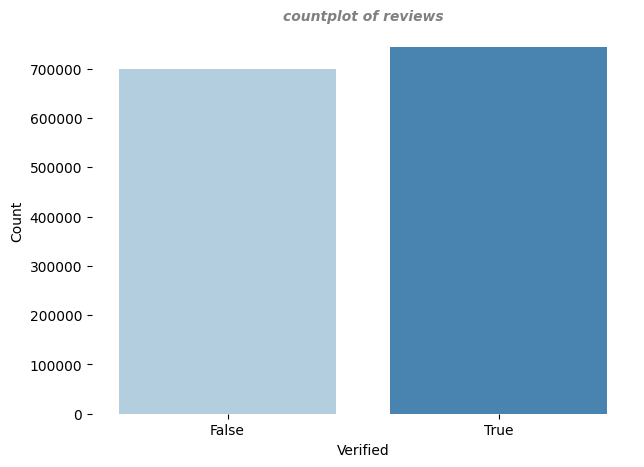

In [ ]:
f, ax = plt.subplots(figsize=(7,5))

sns.countplot(x = myData['verified'], orient = 'h', palette = 'Blues')


# Add label to horiztontal axis
ax.set_xlabel("Verified")

# Remove ylabel
ax.set_ylabel("Count")

# Add a title
ax.set_title("countplot of reviews", fontdict={'size': 10, 'style':'oblique', 'weight': 'heavy', 'color': 'grey'})

# Remove the border line
sns.despine(left=True, bottom=True)

plt.show()

### Most Frequent Words

In [ ]:
# create a function to read the data
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/MyDrive/Colab Notebooks/CDs_and_Vinyl_5.json.gz')
df.head(3)

,reviewerID,asin,reviewerName,verified,reviewText,overall,reviewTime,summary,unixReviewTime,style,vote,image
0,A1H1DL4K669VQ9,0001393774,Judith Paladino,True,Love it!! Great seller!,5.0,"04 29, 2016",Five Stars,1461888000,NaN,NaN,NaN
1,A3V5XBBT7OZG5G,0001393774,gflady,True,One of my very favourite albums from one of my...,5.0,"02 23, 2016",One of my very favourite albums from one of my...,1456185600,NaN,NaN,NaN
2,A3SNL7UJY7GWBI,0001393774,Lady Leatherneck,True,"THank you Jesus Lord God, that brother Green's...",5.0,"02 11, 2016",Five Stars,1455148800,NaN,NaN,NaN


In [ ]:
df = df[df['verified'] == True]
len(df)

743956

In [ ]:
# Create an empty list to store the cleaned tweets # this code only works under pandas.
cleaned_review = []

# Tidy up the tweets

for review in df['reviewText'].apply(str):    # force the json read data to be in string form
  # Remove mentions
  review = re.sub("@[\w]*","",review)
  # Remove http links
  review = re.sub("https?://[a-zA-Z0-9./]*","",review)
  # Remove special characters
  review = re.sub("[^a-zA-Z']"," ",review)
  #Remove leading and trailing whitespaces
  review = review.strip()
  #Restrict the length of the string
  if len(review) > 50:
    cleaned_review.append(review)

In [ ]:
cleaned_review

['One of my very favourite albums from one of my very favourite singers   I was happy to see I could replace the old worn cassettes from years ago',
 "THank you Jesus Lord God  that brother Green's music is still sounding though he is Home with you now",
 "I recall loving his other albums and maybe this one too  forgot but I figured on some of these artists seems like one good album and all good albums  especially in Christian music  seemed when they got into it they stayed into it and so good to double check though if want too but it is a possible very good album because I usually recall if too bad of one and I don't on this one",
 'Keith Green was a pioneer in the field of Christian rock  and I have loved every album he did   This one is particularly sweet as he was just coming into his own as a premier music writer and performer when it was published   His loss was a terrible blow for millions of his fans',
 "Keith Green  amazing gift God gave him     Draw near to God as his music b

In [ ]:
# remove whitespaces
all_reviewed = ' '.join(cleaned_review)


In [ ]:
# Tokenise into words

myWords = word_tokenize(all_reviewed)

In [ ]:
# Count word frequency

fDist = FreqDist(myWords)

In [ ]:
# Remove stop words
# Only keep words with more than 3 letters
# Lowercase the words

# Need a dictionary of stop words

en_stopwords = set(stopwords.words('english'))

myWords_noSW_noCase = [word.lower() for word in myWords if (word.lower() not in en_stopwords) and (len(word)>3)]

In [ ]:
# Count word frequency with the cleaned set

fDist = FreqDist(myWords_noSW_noCase)

# Take a look

fDist.most_common(30)

[('album', 325401),
 ('music', 238297),
 ('great', 222547),
 ('like', 201743),
 ('songs', 190798),
 ('good', 156367),
 ('love', 142135),
 ('song', 133945),
 ('sound', 105342),
 ('best', 103264),
 ('time', 102790),
 ('really', 93502),
 ('first', 90153),
 ('would', 89797),
 ('well', 88456),
 ('band', 86483),
 ('much', 71901),
 ('albums', 69010),
 ('still', 66893),
 ('rock', 65332),
 ('listen', 64431),
 ('also', 61595),
 ('back', 61035),
 ('even', 60489),
 ('better', 59946),
 ('many', 58657),
 ('years', 57299),
 ('tracks', 57250),
 ('voice', 55466),
 ('track', 54307)]

In [ ]:
# Convert the result to a dataframe for visualisation

myreview = pd.DataFrame(fDist.most_common(30), columns=['word', 'frequency'])
myreview

,word,frequency
0,album,325401
1,music,238297
2,great,222547
3,like,201743
4,songs,190798
5,good,156367
6,love,142135
7,song,133945
8,sound,105342
9,best,103264


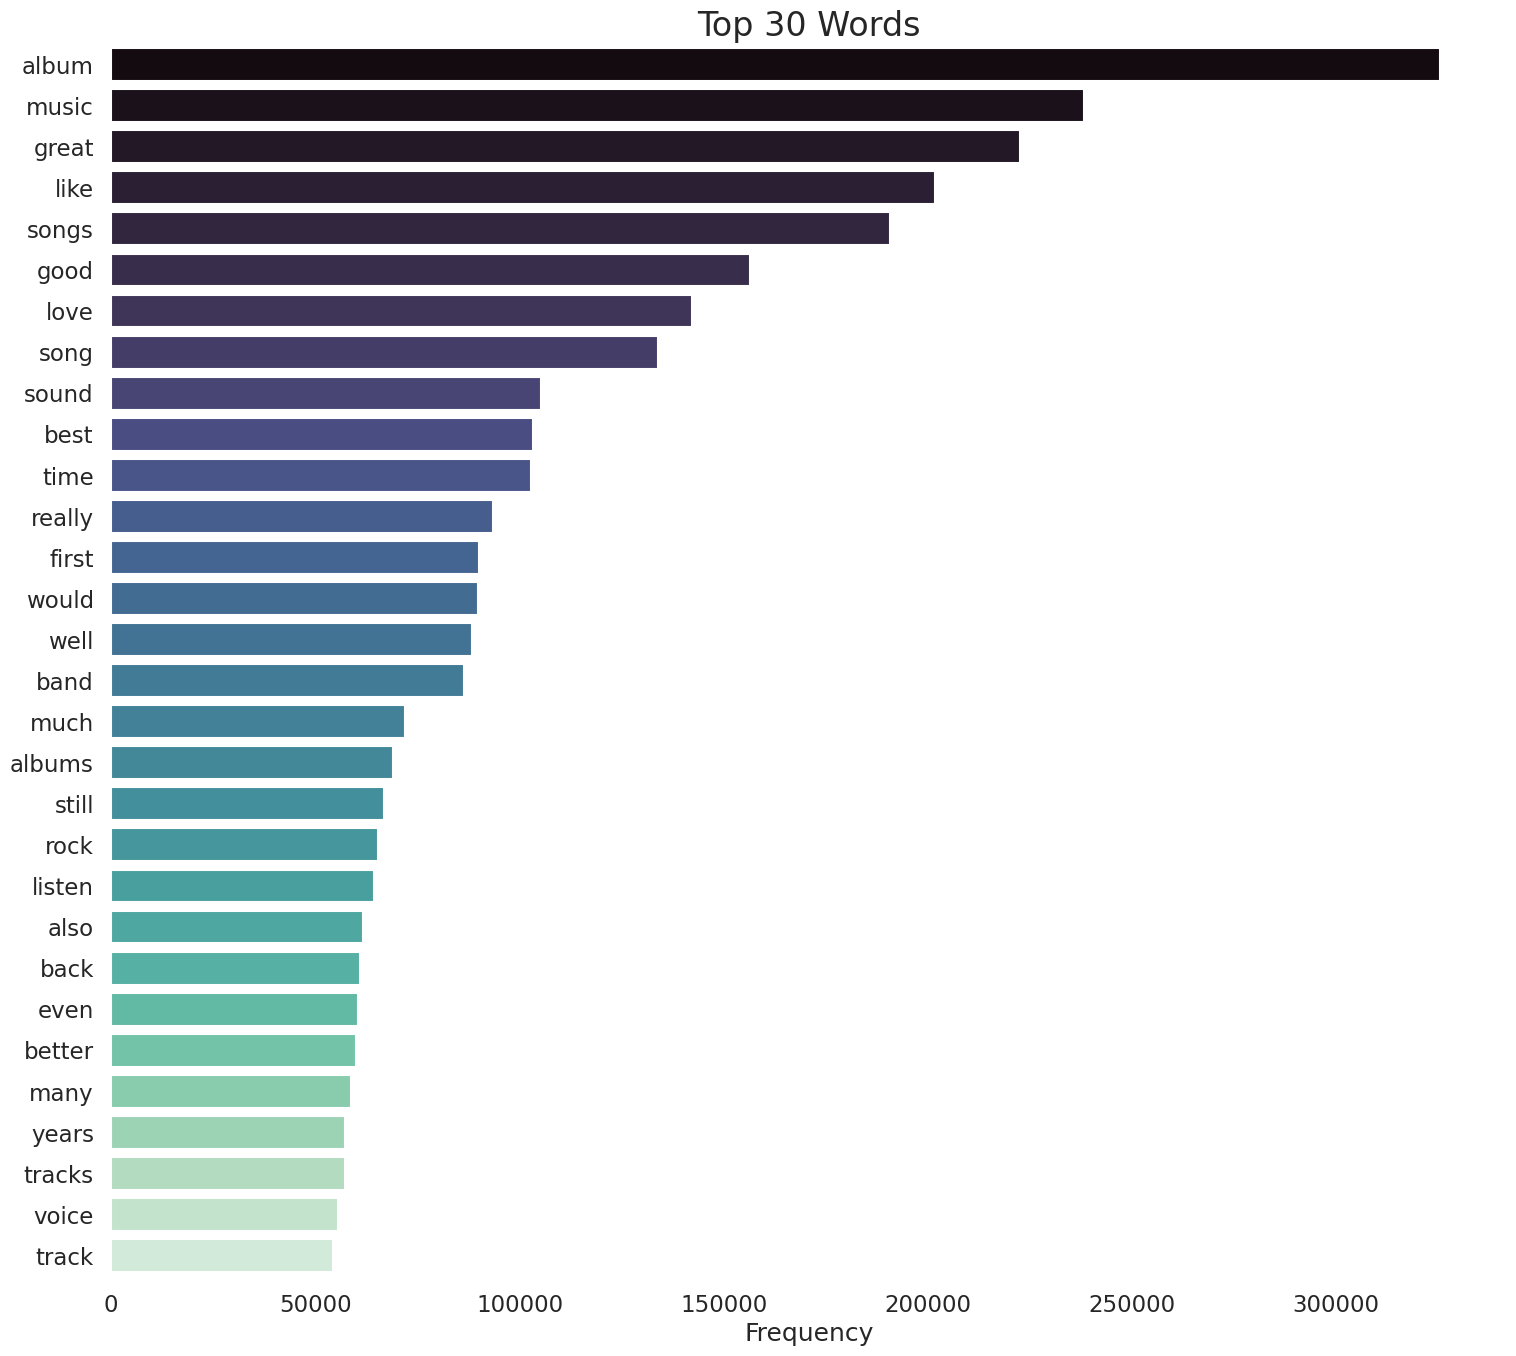

In [ ]:
# Visualise the result

# Set a more specific style
sns.set_theme(style="white", context="talk")
#sns.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,16))

# x and y will control if the barplot is horizontal or vertical
sns.barplot(x="frequency",
            y="word",
            data=myreview,
            palette="mako"
            )

# Add label to horiztontal axis
ax.set_xlabel("Frequency")

# Remove ylabel
ax.set_ylabel("")

# Add a title
ax.set_title("Top 30 Words", fontsize = 24)

# Remove the border line
sns.despine(left=True, bottom=True)

# Save the figure
# plt.savefig("top30.png",
            # bbox_inches="tight",
            # dpi=200)

# Show nicely in the notebook
plt.show()

Findings:
1. The dataset contains reviews from the year 1997 to 2018, with a total of 1, 443, 755 reviews.
2. The years 2013 to 2016 have the most number of reviews.
3. CDs and Vinyl have mostly been rated 5 stars.
4. The top five most frequently used words for this dataset are: Album, Music, Great, Like and Songs.